In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
data = pd.read_csv("play_tennis.csv")
data.head(15)

,day,outlook,temp,humidity,wind,play
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes
5,D6,Rain,Cool,Normal,Strong,No
6,D7,Overcast,Cool,Normal,Strong,Yes
7,D8,Sunny,Mild,High,Weak,No
8,D9,Sunny,Cool,Normal,Weak,Yes
9,D10,Rain,Mild,Normal,Weak,Yes


In [2]:
def entropy(y):
    a = y.value_counts()/y.shape[0]
    entropy = np.sum(-a*np.log2(a))
    return(entropy)
entropy(data.play)  

0.9402859586706311

In [3]:
def information_gain(y, feature):

    total_entropy = entropy(y)
    
    unique_values = feature.unique()
    weighted_entropies = 0

    for value in unique_values:
        subset_y = y[feature == value]
        weighted_entropies += len(subset_y) / len(y) * entropy(subset_y)

    return total_entropy - weighted_entropies


In [4]:
y=data['play']
for column in data.columns:
    if column != 'play' and column != 'day':
    # Your code here
  # Exclude the target variable
        feature = data[column]
        ig = information_gain(y, feature)
        print(f"Feature: {column}, Information Gain: {ig:.4f}")

Feature: outlook, Information Gain: 0.2467
Feature: temp, Information Gain: 0.0292
Feature: humidity, Information Gain: 0.1518
Feature: wind, Information Gain: 0.0481


In [5]:
class Node:
    def __init__(self, feature=None, value=None, entropy=None, information_gain=None, left=None, right=None):
        self.feature = feature
        self.value = value
        self.entropy = entropy
        self.information_gain = information_gain
        self.left = left
        self.right = right


In [6]:
def build_decision_tree(X, y):
    if entropy(y) == 0:
        # If all instances have the same class, create a leaf node
        return Node(value=y.iloc[0])

    if X.empty:
        # If no features left, create a leaf node with the majority class
        return Node(value=y.value_counts().idxmax())

    # Find the best feature to split on
    best_feature = None
    max_info_gain = -1

    for feature_name in X.columns:
        current_info_gain = information_gain(y, X[feature_name])
        if current_info_gain > max_info_gain:
            max_info_gain = current_info_gain
            best_feature = feature_name

    # Create a node with the best feature
    node = Node(feature=best_feature, entropy=entropy(y), information_gain=max_info_gain, value={})

    # Recursively build the left and right subtrees
    unique_values = X[best_feature].unique()
    for value in unique_values:
        subset_X = X[X[best_feature] == value].drop(columns=[best_feature])
        subset_y = y[X[best_feature] == value]
        child_node = build_decision_tree(subset_X, subset_y)

        if node.value is None:
            node.value = {value: child_node}
        else:
            node.value[value] = child_node

    return node


In [7]:
X = data.drop(columns=['play','day'])
y = data['play']
decision_tree = build_decision_tree(X, y)


In [14]:
from sklearn.metrics import accuracy_score

def predict(node, instance):
    if node.feature is None:
        return node.value
    else:
        value = instance[node.feature]
        if value in node.value:
            return predict(node.value[value], instance)
        else:
            return node.value

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the decision tree on the training set
decision_tree = build_decision_tree(X_train, y_train)

# Predict on the testing set
y_pred = [predict(decision_tree, instance) for _, instance in X_test.iterrows()]

# Evaluate accuracy using accuracy_score
accuracy_score = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_score:.2f}")


Accuracy: 1.00


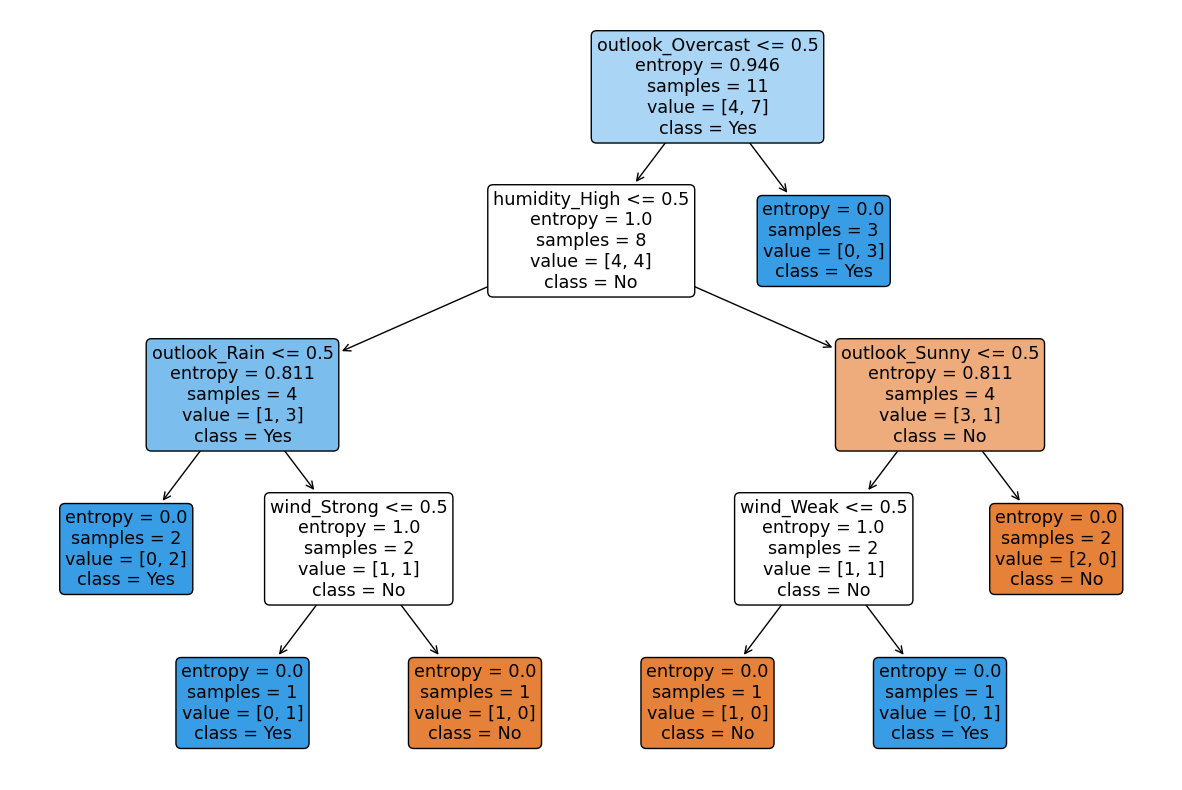

In [15]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Build a decision tree classifier using scikit-learn
dt_classifier = DecisionTreeClassifier(criterion='entropy')
dt_classifier.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_classifier, feature_names=X_train.columns, class_names=y.unique(), filled=True, rounded=True)
plt.show()
